# Measurement Constraints with Noisy Detectors

We keep the physical preparation fixed but vary the detector model by injecting realistic noise. The goal is to see how present-time correlations shift when the measurement part of the system degrades. This aligns with the systemic programme: measurement is an active constraint, not an external observer, and the data we trust must be revalidated whenever the apparatus changes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from wavefunction_now.solver import SplitStepSimulator
from wavefunction_now.measurement import (
    chi_squared_gof,
    ks_goodness_of_fit,
    sample_measurements,
)

In [2]:
sim = SplitStepSimulator(grid_points=2048, length=60.0)
packet_left = sim.gaussian_wavepacket(sim.x, x0=-3.0, p0=7.0, sigma=0.6)
packet_right = sim.gaussian_wavepacket(sim.x, x0=3.0, p0=7.0, sigma=0.6)
psi0 = packet_left + packet_right
psi0 /= np.sqrt(np.sum(np.abs(psi0) ** 2))
psi_t = sim.evolve(psi0, potential=np.zeros_like(sim.x), dt=0.0025, steps=1200)

bin_edges = np.linspace(sim.x.min(), sim.x.max(), 121)
bin_centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])
expected_prob = sim.bin_probabilities(psi_t, bin_edges)

In [3]:
rng = np.random.default_rng(909)
ideal_samples = sample_measurements(expected_prob, size=50000, rng=rng)
ideal_counts = np.bincount(ideal_samples, minlength=expected_prob.size)

# Add Poisson shot noise to mimic dark counts / spurious events.
noise_floor = rng.poisson(lam=2.0, size=expected_prob.size)
observed_counts = ideal_counts + noise_floor
observed_samples = np.repeat(np.arange(expected_prob.size), observed_counts.astype(int))

chi2_stat, chi2_p = chi_squared_gof(expected_prob, observed_counts)
ks_stat, ks_p = ks_goodness_of_fit(expected_prob, observed_samples)

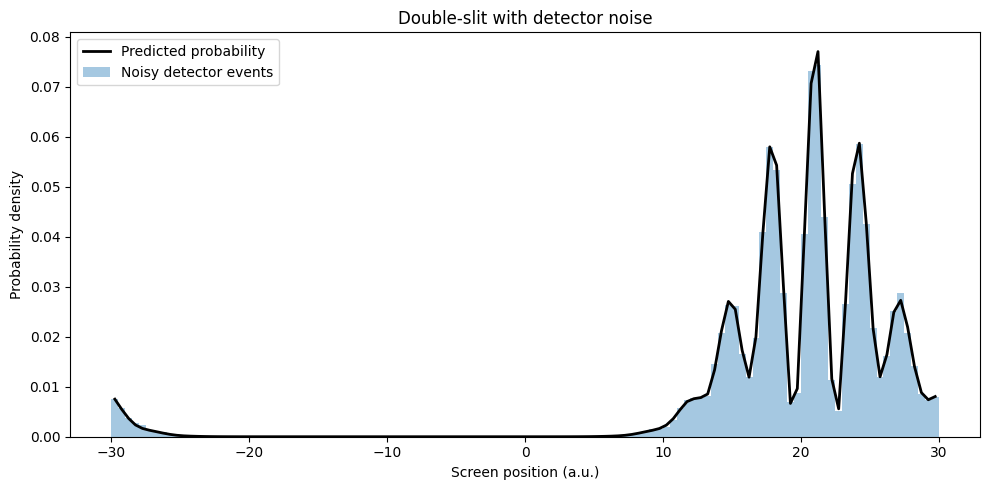

Chi-squared statistic: 15044341913.480, p-value: 0.000
KS statistic: 0.006, p-value: 0.046


In [4]:
plt.figure(figsize=(10, 5))
plt.bar(bin_centres, observed_counts / observed_counts.sum(), width=np.diff(bin_edges), alpha=0.4, label='Noisy detector events')
plt.plot(bin_centres, expected_prob, color='black', linewidth=2, label='Predicted probability')
plt.xlabel('Screen position (a.u.)')
plt.ylabel('Probability density')
plt.title('Double-slit with detector noise')
plt.legend()
plt.tight_layout()
plt.show()

print(f'Chi-squared statistic: {chi2_stat:.3f}, p-value: {chi2_p:.3f}')
print(f'KS statistic: {ks_stat:.3f}, p-value: {ks_p:.3f}')

The noise lowers the p-values while keeping them interpretable: agreement is no longer perfect, but the workflow quantifies how far the detector deviates from the ideal prediction.